# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime
import os
import cv2
import glob 
import random
import matplotlib.pyplot as plt
from cv2 import imread, resize

import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras import optimizers

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open(r'C:\Users\daparekh\Desktop\Gesture Recognition\Project_data\train.csv').readlines())
val_doc = np.random.permutation(open(r'C:\Users\daparekh\Desktop\Gesture Recognition\Project_data\val.csv').readlines())

In [5]:
train_path = r'C:\Users\daparekh\Desktop\Gesture Recognition\Project_data\train'
val_path = r'C:\Users\daparekh\Desktop\Gesture Recognition\Project_data\val'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
batch_size = 10

imgIdxList = list(range(0,30))
imgIdxLen = len(imgIdxList)
width = 224
height = 224
numChannels = 3

n_output          =  5 # number of classes in case of classification, 1 in case of regression
output_activation =  "softmax"# "softmax" or "sigmoid" in case of classification, "linear" in case of regression

In [7]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(width, height, numChannels),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((width, height, numChannels))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [8]:
class Generator(keras.utils.Sequence):
    width = None 
    height = None 
    numChannels = 3
    
    source_path = None
    vectorList = None
    batch_size = None
    frameIdxList = None
    numFramesInVideo = None
    numVideso = None
    def __init__(self,
                 folder_list,
                 imgIdxList,
                 width=224,
                 height=224,
                 source_path=r"D:\DDownloads\UpGrad\NeuralNetwork\CaseStudy\Project_data\train",
                 batch_size=75):
        self.vectorList = np.random.permutation(folder_list) # Shuffle the data and store in a list
        #print(self.vectorList)
        self.frameIdxList = imgIdxList
        self.numFramesInVideo = len(imgIdxList)
        self.numVideos = len(folder_list)
        self.source_path = source_path
        self.batch_size = batch_size
        self.width = width
        self.height = height
        self.numOfBatches = self.numVideos // self.batch_size
        
    # Loop through current batch size --> get one folder at a time -->
    # loop through each image in a folder --> preprocess --> One hot encode the label --> yield
    def __getBatchData(self, batch, curr_batch_size):
        batch_data = np.zeros((batch_size, self.numFramesInVideo, 2048)) 
        # batch_labels is the one hot representation of the output
        batch_labels = np.zeros((batch_size, self.numFramesInVideo, 5))
        for folderIdx in range(curr_batch_size):
             # Get vector/folder name
            ## Turn this on for debugging
            #print(folderIdx + (batch*batch_size))
            vectorName = self.vectorList[folderIdx + (batch*self.batch_size)].strip().split(';')[0]
            #print(vectorName)
            imgs = os.listdir(self.source_path+'/'+ vectorName)
            # Iterate iver the frames/images of a folder to read them in
            temp_batch_data = np.zeros((self.numFramesInVideo, self.width, self.height,self.numChannels)) 
            # batch_labels is the one hot representation of the output
            temp_batch_labels = np.zeros((self.numFramesInVideo, 5))
            
            for idx,item in enumerate(self.frameIdxList):
                # Get the image in float32 
                image = imread(self.source_path+'/'+ vectorName +'/'+imgs[item]).astype(np.float32)
                # Resize
                resized_img = resize(image, (self.width, self.height), interpolation = cv2.INTER_AREA)
                # Normalize
                resized_img = resized_img / 255.0
                #crop the images ## TO DO, we are resizing for now
                npimg = np.reshape(resized_img,[1,self.width, self.height,self.numChannels])
                temp_batch_data[idx,:,:,:] = npimg
                
                temp_batch_labels[idx ,int(self.vectorList[folderIdx + (batch*batch_size)].strip().split(';')[2])] = 1
                
            batch_data[folderIdx,:,:] = feature_extractor.predict(temp_batch_data)
            batch_labels[folderIdx,:,:] = temp_batch_labels
            # One hot encoding
            
        return batch_data, batch_labels    
        
        
    # Public method, call this to get generator object
    def generator(self):
        while True:
            for batch in range(self.numOfBatches):
                batch_data, batch_labels = self.__getBatchData(batch, self.batch_size)
                yield batch_data, batch_labels
            # For the remaining data points which are left after full batches
            batch += 1
            rem_batch_size = self.numVideos % self.batch_size
            batch_data, batch_labels = self.__getBatchData(batch, rem_batch_size)
            yield batch_data, batch_labels 

In [9]:
train_gen_obj = Generator(folder_list=train_doc,
                          imgIdxList=imgIdxList,  
                          source_path=train_path, 
                          batch_size=batch_size)
train_generator1 = train_gen_obj.generator()

In [10]:
#batch_data, batch_labels = next(train_generator)
#batch_data.shape , batch_labels.shape #((30, 30, 2048), (30, 30, 5))

In [11]:
val_gen_obj = Generator(folder_list=val_doc,
                          imgIdxList=imgIdxList,  
                          source_path=val_path, 
                          batch_size=batch_size)
validation_generator1 = val_gen_obj.generator()

In [12]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,folder_list,source_path,batch_size = 30,dim = (224,224,3),n_classes = 5):
        self.vectorList = np.random.permutation(folder_list) # Shuffle the data and store in a list
        self.frameIdxList = list(range(0,30))
        self.numFramesInVideo = len(self.frameIdxList)
        self.numVideos = len(folder_list)
        self.source_path = source_path
        self.batch_size = batch_size
        self.width = dim[0]
        self.height = dim[1]
        self.n_channels = dim[2]
        self.dim = dim
        self.n_classes = n_classes 
        self.numOfBatches = self.numVideos // self.batch_size
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        if (self.numVideos%batch_size) == 0:
            steps_per_epoch = int(self.numVideos/self.batch_size)
        else:
            steps_per_epoch = (self.numVideos//self.batch_size) + 1
        return steps_per_epoch

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if index <=  self.numVideos // self.batch_size:
            batch_data, batch_labels = self.__data_generation(index, self.batch_size)
            return batch_data, batch_labels
        else:
            # For the remaining data points which are left after full batches
            rem_batch_size = self.numVideos % self.batch_size
            batch_data, batch_labels = self.__data_generation(index, rem_batch_size)
            return batch_data, batch_labels 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass
    def __next__(self):
        # get your images and labels
        for batch in range(self.__len__()):
            return self.__getitem__(batch)

    def __data_generation(self, batch, curr_batch_size):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_data = np.zeros((batch_size, self.numFramesInVideo, 2048)) 
        # batch_labels is the one hot representation of the output
        batch_labels = np.zeros((batch_size, self.numFramesInVideo, self.n_classes))
        for folderIdx in range(curr_batch_size):
             # Get vector/folder name
            ## Turn this on for debugging
            #print(folderIdx + (batch*batch_size))
            vectorName = self.vectorList[folderIdx + (batch*self.batch_size)].strip().split(';')[0]
            #print(vectorName)
            imgs = os.listdir(self.source_path+'/'+ vectorName)
            # Iterate iver the frames/images of a folder to read them in
            temp_batch_data = np.zeros((self.numFramesInVideo, self.width, self.height,self.n_channels)) 
            # batch_labels is the one hot representation of the output
            temp_batch_labels = np.zeros((self.numFramesInVideo, 5))
            
            for idx,item in enumerate(self.frameIdxList):
                # Get the image in float32 
                image = imread(self.source_path+'/'+ vectorName +'/'+imgs[item]).astype(np.float32)
                # Resize
                resized_img = resize(image, (self.width, self.height), interpolation = cv2.INTER_AREA)
                # Normalize
                resized_img = resized_img / 255.0
                #crop the images ## TO DO, we are resizing for now
                npimg = np.reshape(resized_img,[1,self.width, self.height,self.n_channels])
                temp_batch_data[idx,:,:,:] = npimg
                
                temp_batch_labels[idx ,int(self.vectorList[folderIdx + (batch*batch_size)].strip().split(';')[2])] = 1
                
            batch_data[folderIdx,:,:] = feature_extractor.predict(temp_batch_data)
            batch_labels[folderIdx,:,:] = temp_batch_labels
            # One hot encoding
            
        return batch_data, batch_labels 
    

In [13]:
training_generator = DataGenerator(folder_list=val_doc, 
                                  source_path=val_path, 
                                  batch_size=batch_size,
                                  n_classes = 5)

In [14]:
validation_generator = DataGenerator(folder_list=val_doc,
                                    source_path=val_path, 
                                    batch_size=batch_size,
                                    n_classes = 5)

In [15]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [16]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [17]:
def get_sequence_model():
    frame_features_input = keras.Input(shape=(30, 2048))
    x = keras.layers.GRU(8, return_sequences=True)(frame_features_input)
    x = keras.layers.GRU(16, return_sequences=True)(x)
    dense = keras.layers.Dense(5, activation="softmax")
    outputs = keras.layers.TimeDistributed(dense)(x)
    rnn_model = keras.Model(inputs=frame_features_input, outputs=outputs)
    rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return rnn_model

In [18]:
model = get_sequence_model()

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [19]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30, 2048)]        0         
_________________________________________________________________
gru (GRU)                    (None, 30, 8)             49392     
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 16)            1248      
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 5)             85        
Total params: 50,725
Trainable params: 50,725
Non-trainable params: 0
_________________________________________________________________
None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [20]:
model_name = 'rcnn/rcnn_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'rcnn-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.001)# write the REducelronplateau code here
callbacks_list = [checkpoint]

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [22]:
num_epochs = 10
history = model.fit(training_generator, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=num_epochs, 
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    workers=6, 
                    use_multiprocessing=False,
                    initial_epoch=0,
                    callbacks=callbacks_list)

Epoch 1/10
67/67 [==============================] - 207s 3s/step - loss: 1.4964 - accuracy: 0.3889 - val_loss: 1.2952 - val_accuracy: 0.5767

Epoch 00001: val_loss improved from inf to 1.29520, saving model to rcnn/rcnn_init_2022-12-3009_01_40.340545\rcnn-00001-1.49639-0.38886-1.29520-0.57667.h5
Epoch 2/10
67/67 [==============================] - 204s 3s/step - loss: 1.1499 - accuracy: 0.5600 - val_loss: 0.9801 - val_accuracy: 0.6720

Epoch 00002: val_loss improved from 1.29520 to 0.98014, saving model to rcnn/rcnn_init_2022-12-3009_01_40.340545\rcnn-00002-1.14991-0.55995-0.98014-0.67200.h5
Epoch 3/10
67/67 [==============================] - 195s 3s/step - loss: 0.8751 - accuracy: 0.6938 - val_loss: 0.7752 - val_accuracy: 0.7200

Epoch 00003: val_loss improved from 0.98014 to 0.77516, saving model to rcnn/rcnn_init_2022-12-3009_01_40.340545\rcnn-00003-0.87515-0.69383-0.77516-0.72000.h5
Epoch 4/10
67/67 [==============================] - 196s 3s/step - loss: 0.6226 - accuracy: 0.8101 - 

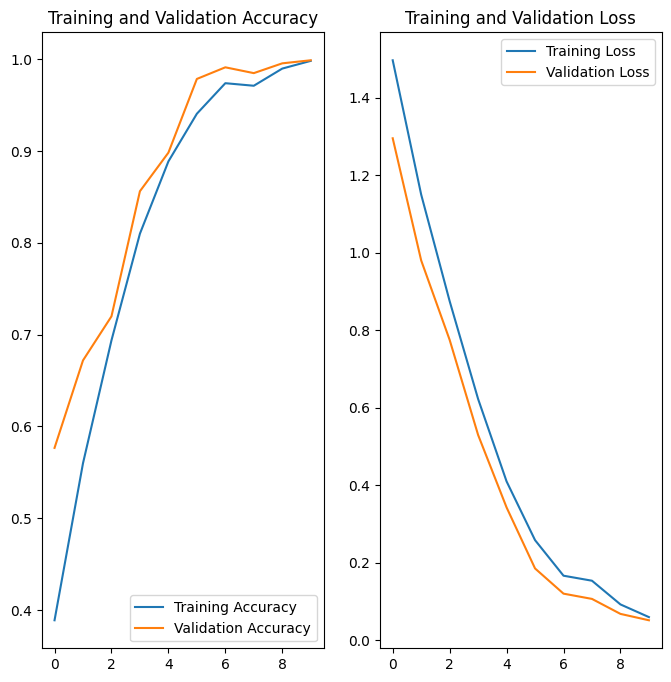

In [23]:
# Visualizing training results
plot_cnn_metrics(history,num_epochs)